In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.


In [4]:
from cosmodc2.sdss_colors import mock_magr

mock['restframe_extincted_sdss_abs_magr'] = mock_magr(
            mock['upid'], mock['obs_sm'], mock['sfr_percentile'], 
            mock['host_halo_mvir'], sdss['sm'], sdss['sfr_percentile_fixed_sm'], 
            sdss['restframe_extincted_sdss_abs_magr'], sdss['z'])


In [5]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

magr = mock['restframe_extincted_sdss_abs_magr'] 
percentile = mock['sfr_percentile']
redshift = np.zeros_like(magr)

gr, ri, is_red_ri, is_red_gr = gr_ri_monte_carlo(
    magr, percentile, redshift, local_random_scale=0.1)

mock['restframe_extincted_sdss_gr'] = gr
mock['restframe_extincted_sdss_ri'] = ri
mock['is_red_gr'] = is_red_gr
mock['is_red_ri'] = is_red_ri


from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color
_result = remap_cluster_bcg_gr_ri_color(
        mock['upid'], mock['host_halo_mvir'], 
        np.copy(mock['restframe_extincted_sdss_gr']), 
        np.copy(mock['restframe_extincted_sdss_ri']), 
        mock['is_red_gr'], mock['is_red_ri'])
gr_remapped, ri_remapped, is_red_gr_remapped, is_red_ri_remapped = _result

mock['_gr_no_remap'] = np.copy(mock['restframe_extincted_sdss_gr'])
mock['_ri_no_remap'] = np.copy(mock['restframe_extincted_sdss_ri'])
mock['restframe_extincted_sdss_gr'] = gr_remapped
mock['restframe_extincted_sdss_ri'] = ri_remapped
mock['_is_red_ri_no_remap'] = np.copy(is_red_ri)
mock['_is_red_gr_no_remap'] = np.copy(is_red_gr)
mock['is_red_gr'] = is_red_gr_remapped
mock['is_red_ri'] = is_red_ri_remapped


In [6]:
from cosmodc2.sdss_colors.fix_cluster_lf import cluster_bcg_red_sequence_gr_ri
from halotools.empirical_models import conditional_abunmatch


def prob_remap_cluster_satellite(upid, mstar, host_halo_mvir,
            x1=(9, 9.75, 10.25, 11), y1=(1., 1., 1., 1.),
            x2=(13.5, 14, 14.5), y2=(0.0, 0.5, 0.75)):
    """
    """
    ngals = len(mstar)
    satmask = upid != -1
    mstar_prob = np.interp(np.log10(mstar), x1, y1)
    mhost_prob = np.interp(np.log10(host_halo_mvir), x2, y2)
    mstar_mask = np.random.rand(ngals) < mstar_prob
    mhost_mask = np.random.rand(ngals) < mhost_prob
    remapping_mask = mstar_mask & mhost_mask & satmask
    return remapping_mask


def remap_satellites(mstar, gr, ri, 
                     gr_red_sequence_median, ri_red_sequence_median, 
                     gr_red_sequence_scatter, ri_red_sequence_scatter,
                    nwin=301):
    """
    """
    num_to_remap = len(mstar)
    bcg_red_sequence_gr, bcg_red_sequence_ri = cluster_bcg_red_sequence_gr_ri(
        num_to_remap, gr_red_sequence_median,
        ri_red_sequence_median, gr_red_sequence_scatter)

    input_gr = gr
    desired_gr = bcg_red_sequence_gr
    output_gr = conditional_abunmatch(
        mstar, input_gr, mstar, desired_gr, nwin)

    desired_ri = bcg_red_sequence_ri
    noisy_input_gr = np.random.normal(loc=output_gr, scale=0.1)
    output_ri = conditional_abunmatch(
        mstar, noisy_input_gr, mstar, desired_ri, nwin)
    return output_gr, output_ri

In [7]:
from cosmodc2.sdss_colors.analytical_colors import red_sequence_peak_gr, red_sequence_peak_ri
from cosmodc2.sdss_colors.analytical_colors import red_sequence_width_gr, red_sequence_width_ri

remapping_mask = prob_remap_cluster_satellite(mock['upid'], mock['obs_sm'],
                        mock['host_halo_mvir'])

gr_peak = red_sequence_peak_gr(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
ri_peak = red_sequence_peak_ri(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
gr_scatter = 0.04
ri_scatter = 0.03

mstar = mock['obs_sm'][remapping_mask]
gr = mock['restframe_extincted_sdss_gr'][remapping_mask]
ri = mock['restframe_extincted_sdss_ri'][remapping_mask]
new_gr, new_ri = remap_satellites(mstar, gr, ri, gr_peak, ri_peak, gr_scatter, ri_scatter)

mock['restframe_extincted_sdss_gr'][remapping_mask] = new_gr
mock['restframe_extincted_sdss_ri'][remapping_mask] = new_ri


## Assign black hole mass

In [8]:
from cosmodc2.black_hole_modeling import bh_mass_from_bulge_mass
mock['bt'] = np.random.rand(len(mock))
median_bh_mass = bh_mass_from_bulge_mass(mock['obs_sm']*mock['bt'])
mock['bh_mass'] = 10**np.random.normal(loc=np.log10(median_bh_mass), scale=0.3)

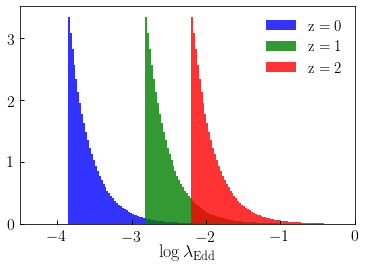

In [23]:
from cosmodc2.black_hole_modeling import monte_carlo_specific_bh_acc_rate
eddington_ratio_z0 = monte_carlo_specific_bh_acc_rate(0., mock['sfr_percentile'])
eddington_ratio_z1 = monte_carlo_specific_bh_acc_rate(1., mock['sfr_percentile'])
eddington_ratio_z2 = monte_carlo_specific_bh_acc_rate(2., mock['sfr_percentile'])

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(eddington_ratio_z0), bins=100, normed=True, 
           alpha=0.8, color='blue', label=r'${\rm z=0}$')
__=ax.hist(np.log10(eddington_ratio_z1), bins=100, normed=True, 
           alpha=0.8, color='green', label=r'${\rm z=1}$')
__=ax.hist(np.log10(eddington_ratio_z2), bins=100, normed=True, 
           alpha=0.8, color='red', label=r'${\rm z=2}$')

legend = ax.legend()
xlabel = ax.set_xlabel(r'${\rm \log \lambda_{Edd}}$')
xlim = ax.set_xlim(-4.5, 0)

figname = 'black_hole_eddington_ratios_redshift_evolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

### Plot redshift-dependence

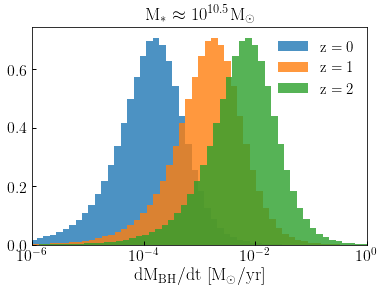

In [88]:
sm_mask = mock['obs_sm'] > 10**10
sm_mask *= mock['obs_sm'] < 10**10.5
bh_rate_z0 = mock['bh_mass']*eddington_ratio_z0/45./1e6
bh_rate_z1 = mock['bh_mass']*eddington_ratio_z1/45./1e6
bh_rate_z2 = mock['bh_mass']*eddington_ratio_z2/45./1e6

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(bh_rate_z0[sm_mask]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm z=0}$')
__=ax.hist(np.log10(bh_rate_z1[sm_mask]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm z=1}$')
__=ax.hist(np.log10(bh_rate_z2[sm_mask]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm z=2}$')

title = ax.set_title(r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}$}')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend()

xlim = ax.set_xlim(-6, 0)
__=ax.set_xticks((-6, -4, -2, 0))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_redshift_evolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

### Plot color-dependence

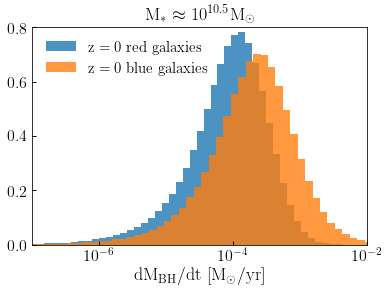

In [89]:
sm_mask = mock['obs_sm'] > 10**10
sm_mask *= mock['obs_sm'] < 10**10.5
median_sfr = np.median(mock['obs_sfr'][sm_mask])

sfr_mask1 = mock['obs_sfr'] < median_sfr
mask1 = sm_mask & sfr_mask1
sfr_mask2 = mock['obs_sfr'] > median_sfr
mask2 = sm_mask & sfr_mask2

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(bh_rate_z0[mask1]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm z=0\ red\ galaxies}$')
__=ax.hist(np.log10(bh_rate_z0[mask2]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm z=0\ blue\ galaxies}$')

ylim = ax.set_ylim(0, 0.8)
title = ax.set_title(r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}$}')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend()

xlim = ax.set_xlim(-7, -2)
__=ax.set_xticks((-6, -4, -2))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_sfr_dependence.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

### Plot mass-dependence

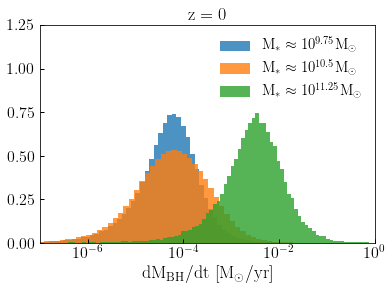

In [99]:
mask1 = (mock['obs_sm'] > 10**9.75) & (mock['obs_sm'] < 10**10)
mask2 = (mock['obs_sm'] > 10**10.5) & (mock['obs_sm'] < 10**10.75)
mask3 = (mock['obs_sm'] > 10**11.25) #& (mock['obs_sm'] < 10**10)

mask2 = sm_mask & sfr_mask2

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(bh_rate_z0[mask1]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm M_{\ast}\approx10^{9.75}M_{\odot}}$')
__=ax.hist(np.log10(bh_rate_z0[mask2]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}}$')
__=ax.hist(np.log10(bh_rate_z0[mask3]), bins=100, normed=True, 
           alpha=0.8, label=r'${\rm M_{\ast}\approx10^{11.25}M_{\odot}}$')

title = ax.set_title(r'${\rm z=0}$')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend()

ylim = ax.set_ylim(0, 1.25)
xlim = ax.set_xlim(-7, 0)
__=ax.set_xticks((-6, -4, -2, 0))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_mstar_dependence.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

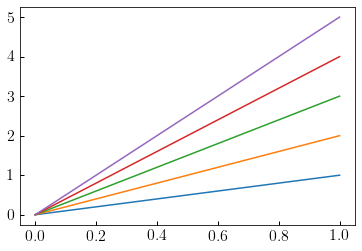

In [115]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 1, 100)
__a=ax.plot(x, x)
__b=ax.plot(x, 2*x)
__c=ax.plot(x, 3*x)
__d=ax.plot(x, 4*x)
__e=ax.plot(x, 5*x)


In [114]:
mpurple = __f[0]._color